In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import datetime as dt
import os

sns.set(style="whitegrid")

# Load data
current_dir = os.getcwd()
data_path = os.path.join(current_dir, '../data/online_retail_ii.xlsx')
df = pd.read_excel(data_path, sheet_name='Year 2010-2011')

# Clean columns
df.columns = df.columns.str.strip()
df = df.dropna(subset=['Customer ID'])
df = df[df['Quantity'] > 0]
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['Price']
if 'Invoice' in df.columns and 'InvoiceNo' not in df.columns:
    df.rename(columns={'Invoice': 'InvoiceNo'}, inplace=True)

print("✅ Data loaded and cleaned.")


✅ Data loaded and cleaned.


In [6]:
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
print("✅ RFM table created.")
rfm.head()


✅ RFM table created.


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


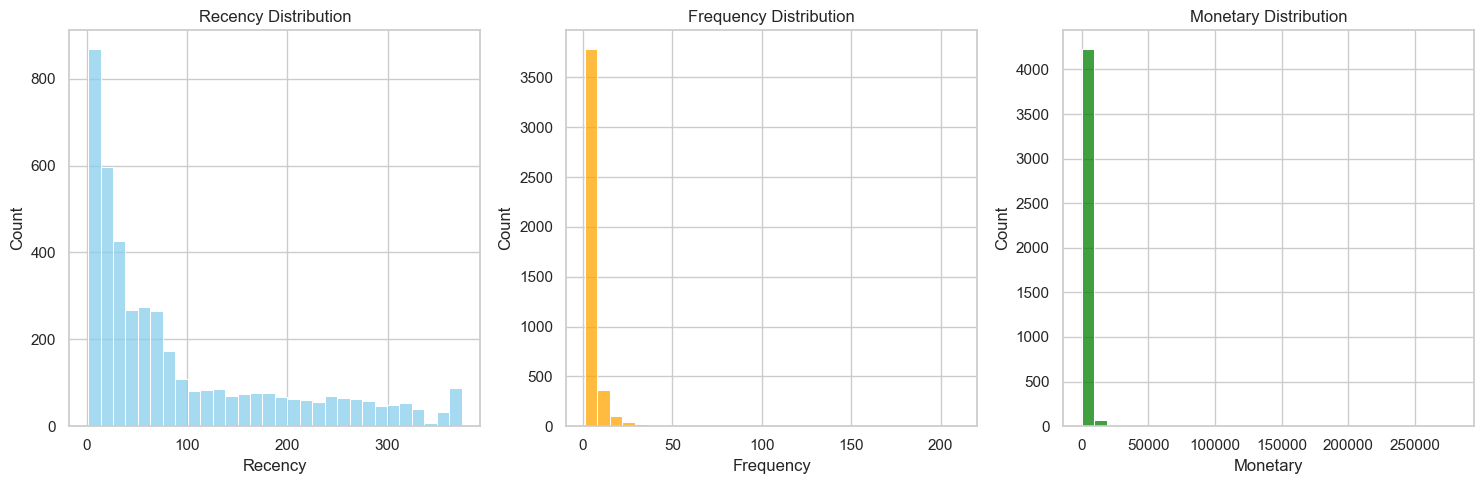

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.histplot(rfm['Recency'], bins=30, ax=axes[0], color='skyblue')
axes[0].set_title('Recency Distribution')

sns.histplot(rfm['Frequency'], bins=30, ax=axes[1], color='orange')
axes[1].set_title('Frequency Distribution')

sns.histplot(rfm['Monetary'], bins=30, ax=axes[2], color='green')
axes[2].set_title('Monetary Distribution')

plt.tight_layout()
plt.show()


In [8]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

kmeans = KMeans(n_clusters=4, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

print("✅ K-Means clustering done!")
rfm['Cluster'].value_counts()


✅ K-Means clustering done!


Cluster
3    3053
1    1062
0     211
2      13
Name: count, dtype: int64

Cluster Profile Summary:


,Recency,Frequency,Monetary
Cluster,,,
0,15.7,22.0,12453.2
1,248.6,1.6,478.1
2,7.4,82.7,127338.3
3,43.9,3.7,1349.7


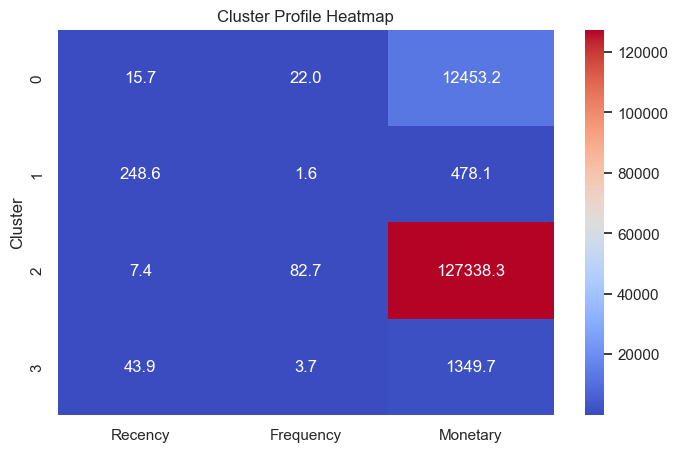

In [9]:
cluster_summary = rfm.groupby('Cluster')[['Recency','Frequency','Monetary']].mean().round(1)
print("Cluster Profile Summary:")
display(cluster_summary)

plt.figure(figsize=(8,5))
sns.heatmap(cluster_summary, annot=True, cmap='coolwarm', fmt='.1f')
plt.title('Cluster Profile Heatmap')
plt.show()


In [10]:
os.makedirs('../reports', exist_ok=True)
rfm.to_csv('../reports/rfm_summary.csv', index=False)
print("✅ RFM summary saved to '../reports/rfm_summary.csv'")


✅ RFM summary saved to '../reports/rfm_summary.csv'


In [11]:
for c in cluster_summary.index:
    r, f, m = cluster_summary.loc[c]
    print(f"Cluster {c}: Recency={r:.1f}, Frequency={f:.1f}, Monetary={m:.1f}")


Cluster 0: Recency=15.7, Frequency=22.0, Monetary=12453.2
Cluster 1: Recency=248.6, Frequency=1.6, Monetary=478.1
Cluster 2: Recency=7.4, Frequency=82.7, Monetary=127338.3
Cluster 3: Recency=43.9, Frequency=3.7, Monetary=1349.7
